In [1]:
import re
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from nltk.corpus import stopwords
from plotly.offline import iplot
import matplotlib.pyplot as plt
import string
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
# from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical
# from keras.callbacks import EarlyStopping
# from keras.layers import Dropout
# import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# nltk.download('stopwords')
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [2]:
train = pd.read_csv('train.csv')

In [3]:
class_5 = train[train['Score'] == 5]
class_4 = train[train['Score'] == 4]
class_3 = train[train['Score'] == 3]
class_2 = train[train['Score'] == 2]
class_1 = train[train['Score'] == 1]

In [4]:
class_1.shape

(39391, 2)

In [ ]:
train['Score'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Reviews', 
                                                                title='Number of reviews in each score')

In [5]:
class_5_count, class_4_count, class_1_count, class_3_count, class_2_count= train['Score'].value_counts()

In [6]:
class_1_count

39391

In [7]:
class_5_under = class_5.sample(class_2_count)
class_4_under = class_4.sample(class_2_count)
class_3_under = class_3.sample(class_2_count)
class_1_under = class_1.sample(class_2_count)

In [8]:
class_3_under.shape

(22438, 2)

In [9]:
train_under = pd.concat([class_5_under, class_4_under, class_3_under, class_2, class_1_under], axis=0)

In [ ]:
train_under.isnull().sum()

In [10]:
for index,text in enumerate(train_under['Review_text'][0:10]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 These Chocolates are so delightful. The actually taste like the deserts described. I love the lemon Tart  very good, Each desert is delectable. I love the variety you get in the package, and the Box is very nicely decorated and gives you a very good description what each desert is. The flavores are so close to the desert is amazing. As the other reviewers stated I thought this would be like any other box of chocolates, I thought they cant be that good, well wrong there fabulous, delish, so tasty, You cant have just one. Very good chocolates. Very Unique
Review 2:
 My Scottie loves this toy!!!!  It keeps him busy for about a half hour and by then he has both of the rawhide thingies off of it...he goes nuts when you give this to him...it's like doggie catnip!!! My dog LOVES this!!!
Review 3:
 After losing 75 lbs. on Atkins Induction, I hit a stall and wanted to add some variety to my WOE. Low carb forums mention coconut oil as a healthy alternative to plain old vegetable oil s

In [17]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
train_under['Clean_txt']=train_under['Review_text'].apply(lambda x:expand_contractions(x))

In [ ]:
train_under['Review_text']=train_under['Review_text'].apply(lambda x: x.lower())

In [ ]:
train_under['Review_text']=train_under['Review_text'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [ ]:
import string
train_under['Review_text']=train_under['Review_text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [ ]:
train_under['Review_text']=train_under['Review_text'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
train_under.shape

In [19]:
for index,text in enumerate(train_under['Clean_txt'][0:10]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 These Chocolates are so delightful. The actually taste like the deserts described. I love the lemon Tart  very good, Each desert is delectable. I love the variety you get in the package, and the Box is very nicely decorated and gives you a very good description what each desert is. The flavores are so close to the desert is amazing. As the other reviewers stated I thought this would be like any other box of chocolates, I thought they cant be that good, well wrong there fabulous, delish, so tasty, You cant have just one. Very good chocolates. Very Unique
Review 2:
 My Scottie loves this toy!!!!  It keeps him busy for about a half hour and by then he has both of the rawhide thingies off of it...he goes nuts when you give this to him...it is like doggie catnip!!! My dog LOVES this!!!
Review 3:
 After losing 75 lbs. on Atkins Induction, I hit a stall and wanted to add some variety to my WOE. Low carb forums mention coconut oil as a healthy alternative to plain old vegetable oil 

In [26]:
# function which will clean the text before processing
def cleanTxt(text):
    text = text.lower()
    STOPWORDS = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    text = re.sub("<br />", ' ',text)
    text = re.sub('\w*\d\w*','', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(' +',' ',text)
    # text = re.compile('[/(){}\[\]\|@,;]').sub(" ", text)
    # text = re.compile('[^0-9a-z #+_]').sub(" ", text)
    # text = re.sub(r'https?:\/\/\S+', '',text) #remove hyperlink
    # # text = re.sub(r'!', '',text) #remove exclamation mark
    # text = (c for c in text if 0 < ord(c) < 127) #removing non ascii characters
    # text = ''.join(text)
    return text

In [27]:
train_under['Clean_txt'] = train_under['Review_text'].apply(cleanTxt)

In [ ]:
train_under['Score'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Reviews', 
                                                                title='Number of reviews in each score')

In [29]:
wordnet_lemma = WordNetLemmatizer()
def lemmatization(text):
    lemma_word = []
    for i in text:
        word1 = wordnet_lemma.lemmatize(i, pos = "n")
        word2 = wordnet_lemma.lemmatize(word1, pos = "v")
        word3 = wordnet_lemma.lemmatize(word2, pos = ("a"))
        lemma_word.append(word3)
    return ''.join(lemma_word)

In [30]:
train_under['Lemmatized_Text'] = train_under['Clean_txt'].apply(lemmatization)

In [28]:
for index,text in enumerate(train_under['Clean_txt'][0:10]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 chocolates delightful actually taste like deserts described love lemon tart good desert delectable love variety get package box nicely decorated gives good description desert is flavores close desert amazing reviewers stated thought would like box chocolates thought cant good well wrong fabulous delish tasty cant one good chocolates unique
Review 2:
 scottie loves toy keeps busy half hour rawhide thingies it he goes nuts give him it s like doggie catnip dog loves this 
Review 3:
 losing lbs atkins induction hit stall wanted add variety woe low carb forums mention coconut oil healthy alternative plain old vegetable oil ordered jar nutiva evco like taste figured could use skin lotion this stuff great far used season beef patties chicken steamed veggies omelets tried coffee good new favorite food item some folks complain coconut smell like it helped get past stall actually lost couple lbs week stuff wonderful buy
Review 4:
 must confess two pugs take say grain salt yes crave fo

In [31]:
train_modified=train_under[['Score', 'Lemmatized_Text']].groupby(by='Score').agg(lambda x:' '.join(x))
train_modified.head()

Lemmatized_Text
Score                                                   
1      flowers showed up pretty bad shape figured wat...
2      really disappointed sorghum purchased users ye...
3      bad lot tea price gunpowder good name it hones...
4      i m pretty happy fence basic above ground elec...
5      chocolates delightful actually taste like dese...

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(train_modified['Lemmatized_Text'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=train_modified.index
df_dtm.head(3)

D:\Anaconda\envs\text-analytics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



aa  aaa  aaaa  aaaaa  aaaaaa  \
Score                                 
1       4    0     0      0       0   
2       7    0     0      0       0   
3      16    0     0      0       0   

       aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa  aaaaaaaaaaaaaaaaaaaargh  \
Score                                                                          
1                                                 0                        0   
2                                                 0                        0   
3                                                 0                        0   

       aaaaaaaaaaacccckkkkk  aaaaaaarrrrrggghhh  aaaaaaggggggghhhhhhhh  ...  \
Score                                                                   ...   
1                         2                   0                      0  ...   
2                         0                   4                      0  ...   
3                         0                   0                      1  ...   

       zylitor  zylotol  zymox  zyto  zzz  zzzzz  zzzzzzz  zzzzzzzzzzz  çelem  \
Score                                                                           
1            0        0      0     0    0      0        1            0      0   
2            1        0      0     0    0      1        0            0      1   
3            0        2      0     0    0      0        0            0      0   

       île  
Score       
1        0  
2        0  
3        0  

[3 rows x 56656 columns]

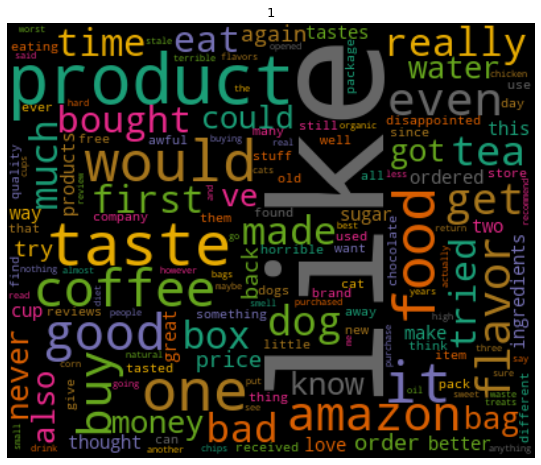

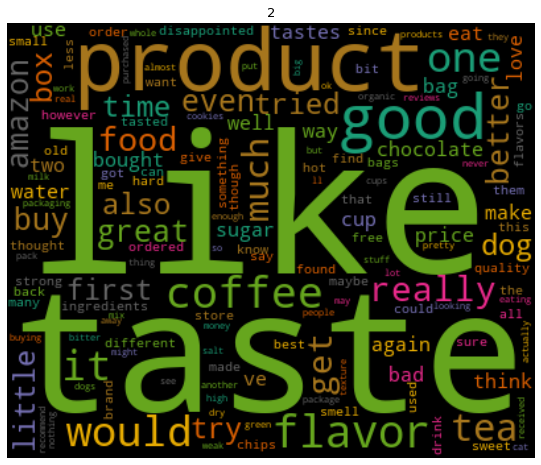

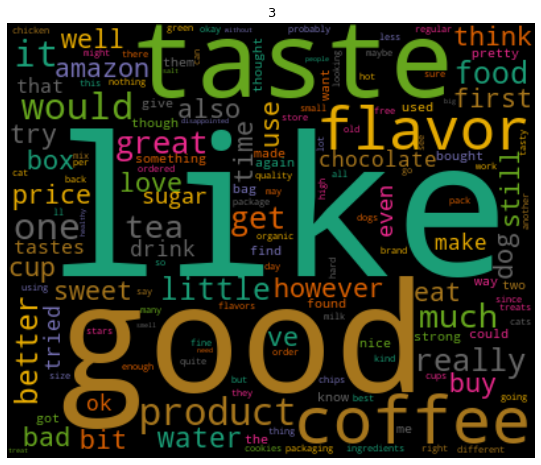

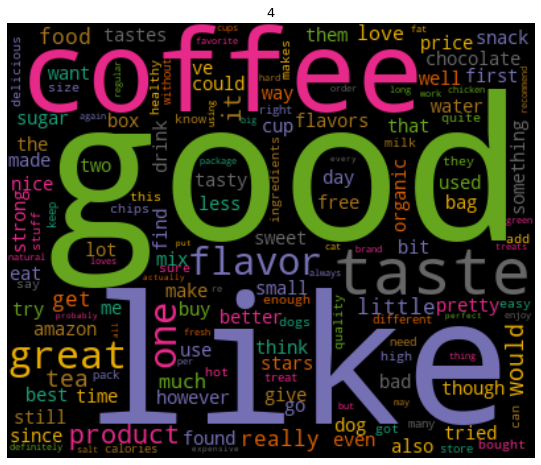

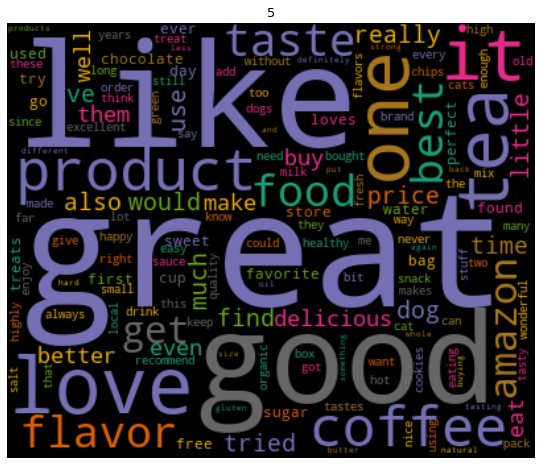

In [33]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title(score,fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each score
for index,score in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[score].sort_values(ascending=False),score)

In [34]:
from textblob import TextBlob
train_under['Polarity'] = train_under['Lemmatized_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [39]:
train_under['Lemmatized_Text'][:3]

175818    chocolates delightful actually taste like dese...
364757    scottie loves toy keeps busy half hour rawhide...
171531    losing lbs atkins induction hit stall wanted a...
Name: Lemmatized_Text, dtype: object

In [60]:
train_under.sort_values(by=['Polarity'], ascending=True)

Score                                        Review_text  \
10834       2  One of the worst cans of soup I ever tasted. I...   
208082      1  These chips are nasty.  I thought someone had ...   
355828      1  This is worst-tasting soda I've ever had.  I c...   
175301      1  This is the worst coconut water that we have e...   
380501      1  Had planned to give this as a gift until it ar...   
...       ...                                                ...   
232541      5  After eating these you'll Never want another S...   
379919      3  3.84 a package in Houston TX  (Found 1/13/06)<...   
59443       3  There are probably a lot of dogs that would th...   
379969      5  When I want a treat that won't break the bank,...   
82751       4  Re: Durkee Liquid Smoke, 32-Ounce Packages (Pa...   

                                                Clean_txt  \
10834   one worst cans soup ever tasted give remaining...   
208082  chips nasty thought someone spilled drink bag ...   
355828  worst tasting soda i ve ever had can t see any...   
175301  worst coconut water ever tried tastes like coc...   
380501  planned give gift arrived k cups throw brown c...   
...                                                   ...   
232541  eating never want another slim jim these aweso...   
379919   package houston tx found otherwise senseo bes...   
59443   probably lot dogs would think best world malte...   
379969  want treat break bank it twenty four mugs perf...   
82751   re durkee liquid smoke ounce packages pack exc...   

                                          Lemmatized_Text  Polarity  
10834   one worst cans soup ever tasted give remaining...      -1.0  
208082  chips nasty thought someone spilled drink bag ...      -1.0  
355828  worst tasting soda i ve ever had can t see any...      -1.0  
175301  worst coconut water ever tried tastes like coc...      -1.0  
380501  planned give gift arrived k cups throw brown c...      -1.0  
...                                                   ...       ...  
232541  eating never want another slim jim these aweso...       1.0  
379919   package houston tx found otherwise senseo bes...       1.0  
59443   probably lot dogs would think best world malte...       1.0  
379969  want treat break bank it twenty four mugs perf...       1.0  
82751   re durkee liquid smoke ounce packages pack exc...       1.0  

[112190 rows x 5 columns]

In [58]:
polarity_highest = train_under.sort_values(by=['Polarity'], ascending=False)
print("3 Random Reviews with Highest Polarity:")
for index,review in enumerate(polarity_highest['Review_text']):
    if index == 3:
        break
    print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Highest Polarity:
Review 1:
 This flour makes all the difference in the world when it comes to making pasta or pizza and this seller has the best price and fastest turnaround time I will defiantly be ordering more soon!! The best!
Review 2:
 I've lost 17 lbs in 23 days eating steak, this delicious barbeque sauce and other Walden products.  I eat it still even when I'm not still dieting. Delicious
Review 3:
 You can get a 14.5 oz bag at Costco for $6.99. This 3.5 oz bag is overpriced at about $9.00! Delicious but


In [61]:
polarity_lowest = train_under.sort_values(by=['Polarity'], ascending=True)
print("3 Random Reviews with Lowest Polarity:")
for index,review in enumerate(polarity_lowest['Review_text']):
    if index == 3:
        break
    print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Lowest Polarity:
Review 1:
 One of the worst cans of soup I ever tasted. I will give the remaining 11 cans away. YUCK!
Review 2:
 These chips are nasty.  I thought someone had spilled a drink in the bag, no the chips were just soaked with grease.  Nasty!! Disgusting
Review 3:
 This is worst-tasting soda I've ever had.  I can't see how anyone could like it, but I guess there is something out there for everyone.  I imagine it's what tar tastes like. Just AWFUL!
